In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, sys

sys.path.insert(0, '../src/Ostrich_support/')
from cal_metrics_NoRouting import *

In [1]:
# path_bestmodel = '/glade/u/home/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_100_OstCalib/archive/PreserveBestModel'
# path_compare = '/glade/u/home/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_100_OstCalib/archive/PreserveModelOutput/Run_22/'
# add_flow_file = 'file1,file2'
# date_start='1994-10-01'      # start date for calculating statistics
# date_end='1998-10-01'       # end date for calculating statistics
# pathCTSM = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_100'
# ref_streamflow = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_100_OstCalib/refdata/streamflow_data.csv'


path_bestmodel = '/glade/u/home/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_130_OstCalib/archive/PreserveBestModel'
path_compare = '/glade/u/home/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_130_OstCalib/archive/PreserveModelOutput/Run_12/'
add_flow_file = 'file1,file2'
date_start='1994-10-01'      # start date for calculating statistics
date_end='1998-10-01'       # end date for calculating statistics
pathCTSM = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_130'
ref_streamflow = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_130_OstCalib/refdata/streamflow_data.csv'

# path_bestmodel = '/glade/u/home/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_300_OstCalib/archive/PreserveBestModel'
# path_compare = '/glade/u/home/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_300_OstCalib/archive/PreserveModelOutput/Run_3/'
# add_flow_file = 'file1,file2'
# date_start='1985-10-01'      # start date for calculating statistics
# date_end='1989-10-01'       # end date for calculating statistics
# pathCTSM = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_300'
# ref_streamflow = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_300_OstCalib/refdata/streamflow_data.csv'


######## default variable names
clm_q_name = 'QRUNOFF' # default runoff variable name
clm_q_sdim = 'lndgrid' # spatial dim name
ref_q_name = 'Runoff_cms'
ref_q_date = 'Date'
keyword = ".clm2.h1."

CTSMfilelist = glob.glob(f'{path_bestmodel}/*{keyword}*nc')
CTSMfilelist.sort()
CTSMfilelistcomp = glob.glob(f'{path_compare}/*{keyword}*nc')
CTSMfilelistcomp.sort()

NameError: name 'glob' is not defined

In [73]:
########################################################################################################################
# load CTSM streamflow (m3/s)
ds_simu = main_read_CTSM_streamflow(pathCTSM, CTSMfilelist, date_start, date_end, clm_q_name, clm_q_sdim)
ds_simucomp = main_read_CTSM_streamflow(pathCTSM, CTSMfilelistcomp, date_start, date_end, clm_q_name, clm_q_sdim)

########################################################################################################################
# load CAMELS observation streamflow (m3/s)
ds_q_obs = read_CAMELS_Q_and_to_xarray(ref_streamflow, ref_q_date, ref_q_name)

########################################################################################################################
# add upstream flows to simulated streamflow
ds_simu = add_upstream_flow(add_flow_file, ds_simu, ref_q_date, ref_q_name, clm_q_name)
ds_simucomp = add_upstream_flow(add_flow_file, ds_simucomp, ref_q_date, ref_q_name, clm_q_name)

########################################################################################################################
# evaluation

ds_q_obs = ds_q_obs.sel(time=ds_q_obs.time.isin(ds_simu.time))
ds_simucomp = ds_simucomp.sel(time=ds_simucomp.time.isin(ds_q_obs.time))
ds_simu = ds_simu.sel(time=ds_simu.time.isin(ds_q_obs.time))

kge_q = get_modified_KGE(obs=ds_q_obs[ref_q_name].values, sim=ds_simu[clm_q_name].values)
rmse_q = get_RMSE(obs=ds_q_obs[ref_q_name].values, sim=ds_simu[clm_q_name].values)
kge_qcomp = get_modified_KGE(obs=ds_q_obs[ref_q_name].values, sim=ds_simucomp[clm_q_name].values)
rmse_qcomp = get_RMSE(obs=ds_q_obs[ref_q_name].values, sim=ds_simucomp[clm_q_name].values)

print("Calibration KGE':", kge_q)
print("Calibration KGE' comp:", kge_qcomp)

Use streamflow reference file: /glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib_split_nest_LMWG/CAMELS_300_OstCalib/refdata/streamflow_data.csv
File does not exist: file1
Remove it from add flow file list
File does not exist: file2
Remove it from add flow file list
File does not exist: file1
Remove it from add flow file list
File does not exist: file2
Remove it from add flow file list
Calibration KGE': -0.04627916262859255
Calibration KGE' comp: -0.32676432067308947


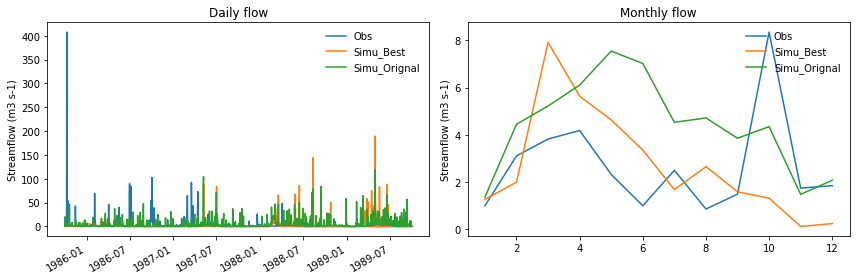

In [74]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])

axi = axs[0]
ds_q_obs.Runoff_cms.plot(ax=axi, label='Obs')
ds_simu.QRUNOFF.plot(ax=axi, label='Simu_Best')
ds_simucomp.QRUNOFF.plot(ax=axi, label='Simu_Orignal')
axi.set_xlabel('')
axi.set_ylabel('Streamflow (m3 s-1)')
axi.set_title('Daily flow')
axi.legend(frameon=False)

axi = axs[1]
ds_q_obs.Runoff_cms.groupby("time.month").mean().plot(ax=axi, label='Obs')
ds_simu.QRUNOFF.groupby("time.month").mean().plot(ax=axi, label='Simu_Best')
ds_simucomp.QRUNOFF.groupby("time.month").mean().plot(ax=axi, label='Simu_Orignal')
axi.set_xlabel('')
axi.set_ylabel('Streamflow (m3 s-1)')
axi.set_title('Monthly flow')
axi.legend(frameon=False)

plt.tight_layout()
# plt.show()
plt.savefig('CAMELS_130_calib_Q.png', dpi=600, bbox_inches='tight', pad_inches=0)